# Scraping Rotten Tomatoes and analyse the dataset

This code will **scrape** the website **Rotten Tomatoes** to get the information of the movies available on the website. The information will be stored in a csv file.
Then, the csv file will be used to **analyse the dataset** to find some interesting information.

## Getting the data


### Loading the films on the website Rotten Tomatoes

In order to get the data, we will use the library **Selenium**. Selenium is a library that allows us to automate the browser. We will use it to click on the button "Load more" to get all the movies available on the website.

In [ ]:
from selenium.common import NoSuchElementException
from selenium import webdriver
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
# The browser will be Chrome
driver = webdriver.Chrome()
# Open the website Rotten Tomatoes
driver.get("https://www.rottentomatoes.com/browse/movies_at_home/sort:popular?page=5")
try:
    # Click on the button "Reject all" to refuse the cookies, if the button exists. Its a button that appears when you first visit the website.
    reject_all_button =driver.find_element(By.ID,"onetrust-reject-all-handler")
    reject_all_button.click()

except NoSuchElementException:
    print('The button does not exist')
    pass
# The number of times we will click on the button "Load more", each time we click on the button, 30 movies will be added to the list of movies.
number_of_reloading = 20
# Click on the button "Load more" the number of times defined by the variable number_of_reloading
for i in range(number_of_reloading):
    try:
        print('Step', i)
        # Find the button "Load more"
        load_more_button = driver.find_element(By.XPATH, "//button[@data-discoverygridsmanager='btnLoadMore']")
        # Click on the button "Load more"
        load_more_button.click()
    except NoSuchElementException:
        print('The button does not exist')
        pass
    # Pause of 0.5 second between each click on the button "Load more" to let the website load the new movies
    time.sleep(0.5) # Pause de 1 seconde
# Get the html code of the page in the variable html
html = driver.page_source
# Close the browser
driver.quit()

### Getting the information of each film on the website Rotten Tomatoes

We will use the library **BeautifulSoup** to get the information of each film. We will get the following information:

- The title
- The tomato
- The audience
- The rating
- The genre
- The original language
- The director
- The producer
- The writer
- The release date (theaters)
- The release date (streaming)
- The box office (gross USA)
- The runtime
- The distributor
- The sound mix

In [ ]:
# Function to get the information of each film
# Input: the html code of the page
# Output: a dictionary with the information of the film
def get_info(soup):
    # Find the list of information
    list = soup.find("ul", {"id" : "info"})
    # Create a dictionary to store the information
    film_details = {}
    # Get the title of the film
    title = soup.find("h1", {"data-qa" : "score-panel-movie-title"}).text

    film_details["title"] = title


    # Get the information of each category

    for child in list.children:
        # If the category is not empty
        if child.find("b") != -1 :
            # Get the category name
            category = child.find("b").text
            # Remove the ":" at the end of the category
            category = category.replace(':','')
            # Get the value of the category
            value = child.find("span").text
            # Remove the "\n" and the " " in the value
            value = value.strip().replace('\n', '').replace(" ",'').replace(",", ' ')
            # Store the category and the value in the dictionary
            film_details[category] = value
    return film_details

In [3]:
# Create a BeautifulSoup object from the html code of the page. This object will allow us to get the information of each film.
soup = BeautifulSoup(html)

In [4]:
# Find all the divs that contain the information of each film. Each div contains the information of one film.
film_divs= soup.findAll(class_='js-tile-link')

In [5]:
# Create a list to store the link of each film details.
films_link = []
for film in film_divs:
    film_link = {}
    # Get the link of the film details
    link_div = (film.find('a', {"data-track" : "scores"}))
    if link_div is not None:
        # Get the tomato and the audience score
        audiencescore = link_div.find("score-pairs")["audiencescore"]
        tomatoescore = link_div.find("score-pairs")["criticsscore"]
        # Store the link of the film details and the tomato and the audience score in the dictionary.
        film_link["link"] = link_div['href']
        film_link["audiencescore"] = audiencescore
        film_link["tomatoescore"]  = tomatoescore
        films_link.append(film_link)

In [6]:
# Base url of the website
base_url = 'https://www.rottentomatoes.com'
film_details_list = []
number_film = 0
for film_name in films_link:
    print(number_film, "/", len(films_link))
    # Get the url of the film details
    url = base_url + film_name["link"]
    print(url)
    # Get the html code of the page
    response = requests.get(url)
    if response.ok:
        # Create a BeautifulSoup object from the html code of the page. This object will allow us to get the information of each film.
        soup = BeautifulSoup(response.content)
        # Get the information of the film. The function get_info is defined above. It returns a dictionary with the information of the film.
        infos = get_info(soup)
        # Add the tomato and the audience score to the dictionary.
        infos["audiencescore"] = film_name["audiencescore"]
        infos["tomatoescore"] = film_name["tomatoescore"]
        # Add the dictionary to the list.
        film_details_list.append(infos)
    number_film += 1


In [ ]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame(data=film_details_list)
# Drop the columns "View the collection" and "Aspect Ratio"
df = df.drop(["View the collection", "Aspect Ratio"], axis=1)

In [ ]:
# Reorder the columns of the dataframe.
df = df[['title', 'tomatoescore','audiencescore','Rating', 'Genre', 'Original Language', 'Director', 'Producer',
       'Writer', 'Release Date (Theaters)', 'Release Date (Streaming)',
       'Box Office (Gross USA)', 'Runtime', 'Distributor', 'Sound Mix']]

In [11]:
# Remove the NaN values, by replacing them with an empty string.
df = df.fillna('')

In [ ]:
# Transform the string of the columns Genre, Director, Producer and Writer into a list of strings. For example, the string "Action, Adventure, Comedy" will be transformed into the list ["Action", "Adventure", "Comedy"]
df['Genre'] = df['Genre'].apply(lambda x: x.split())
df['Director'] = df['Director'].apply(lambda x: x.split())
df['Producer'] = df['Producer'].apply(lambda x: x.split())
df['Writer'] = df['Writer'].apply(lambda x: x.split())


In [30]:
df.head(10)

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
0,Everything Everywhere All at Once,94.0,86.0,R(SexualMaterial|Language|SomeViolence),"[""['Comedy',"", ""'Adventure',"", ""'Sci-fi',"", ""'...",English,"[""['DanKwan',"", ""'DanielScheinert']""]","[""['JoeRusso',"", ""'AnthonyRusso',"", ""'MikeLaro...","[""['DanKwan',"", ""'DanielScheinert']""]",Apr8 2022 wide,Jun7 2022,75000000.0,2h12m,A24,DolbyDigital
1,Cocaine Bear,68.0,71.0,R(LanguageThroughout|DrugContent|BloodyViolenc...,"[""['Mystery&thriller',"", ""'Comedy']""]",English,"[""['ElizabethBanks']""]","[""['PhilLord',"", ""'ChrisMiller',"", ""'Elizabeth...","[""['JimmyWarden']""]",Feb24 2023 wide,Mar21 2023,58000000.0,1h35m,UniversalPictures,NaN
2,The Whale,64.0,91.0,R(SexualContent|Language|SomeDrugUse),"[""['Drama']""]",English,"[""['DarrenAronofsky']""]",['[]'],"[""['SamuelD.Hunter']""]",Dec21 2022 wide,Feb21 2023,17000000.0,1h57m,A24,DolbyDigital
3,Boston Strangler,66.0,76.0,R(Language|SomeViolentContent),"[""['Crime',"", ""'Drama']""]",English,"[""['MattRuskin']""]","[""['TomAckerley',"", ""'JoseyMcNamara',"", ""'Mich...","[""['MattRuskin']""]",NaN,Mar17 2023,NaN,1h52m,Hulu,DolbyDigital
4,Dragged Across Concrete,76.0,69.0,R(Language|GrislyImages|SomeSexuality/Nudity|S...,"[""['Crime',"", ""'Drama']""]",English,"[""['S.CraigZahler']""]","[""['KeithKjarval',"", ""'DallasSonnier',"", ""'Tyl...","[""['S.CraigZahler']""]",Mar22 2019 limited,Mar22 2019,NaN,2h39m,SummitEntertainment LionsgateFilms,DolbyDigital
5,Luther: The Fallen Sun,68.0,85.0,R(SomeSexualMaterial|Language|Disturbing/Viole...,"[""['Crime',"", ""'Drama',"", ""'Mystery&thriller']""]",English(UnitedKingdom),"[""['JamiePayne']""]","[""['PeterChernin',"", ""'NeilCross',"", ""'IdrisEl...","[""['NeilCross']""]",Feb24 2023 limited,Mar10 2023,NaN,2h8m,Netflix,DolbyDigital
6,RRR,95.0,94.0,NaN,"[""['Action',"", ""'Drama']""]",Telugu,"[""['S.S.Rajamouli']""]","[""['D.V.V.Danayya']""]","[""['S.S.Rajamouli',"", ""'SaiMadhavBurra']""]",Mar25 2022 wide,May22 2022,596000.0,3h7m,SarigamaCinemas,DolbyAtmos
7,John Wick,86.0,81.0,R(Language|BriefDrugUse|StrongBloodyViolence),"[""['Action',"", ""'Mystery&thriller']""]",English,"[""['ChadStahelski']""]","[""['BasilIwanyk',"", ""'DavidLeitch',"", ""'EvaLon...","[""['DerekKolstad']""]",Oct24 2014 wide,Feb3 2015,43000000.0,1h41m,LionsgateFilms,DolbyDigital DolbyAtmos Datasat
8,Shazam!,90.0,82.0,PG-13(Language|IntenseSequencesofAction|Sugges...,"[""['Action',"", ""'Adventure',"", ""'Comedy',"", ""'...",English,"[""['DavidF.Sandberg']""]","[""['PeterSafran']""]","[""['HenryGayden']""]",Apr5 2019 wide,Jul2 2019,140000000.0,2h12m,WarnerBros.Pictures,DolbyAtmos
9,The Banshees of Inisherin,96.0,75.0,R(LanguageThroughout|BriefGraphicNudity|SomeVi...,"[""['Comedy']""]",English,"[""['MartinMcDonagh']""]","[""['GrahamBroadbent',"", ""'PeterCzernin',"", ""'M...","[""['MartinMcDonagh']""]",Nov4 2022 wide,Dec13 2022,10000000.0,1h49m,SearchlightPictures,DolbyDigital


In [14]:
# Save the dataframe in a csv file
#df.to_csv("FilmCSV.csv")

## Data cleaning

Once we have the data, we need to clean it.

In [19]:
import pandas as pd
# Read the csv file that contains the data. The file is in the same folder as the notebook.
df = pd.read_csv("FilmCSV.csv")

In [20]:
# Remove the column Unnamed: 0. It is not useful.
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df

In [22]:
# This function converts the string of the column Box Office (Gross USA) into a float. For example, the string "$1.2M" will be converted into the float 1200000.0, and the string "$1.2K" will be converted into the float 1200.0.

def convert_value(value):
    #check if the value is not nan
    if type(value) == float:
        return value
    print(value)
    if value[-1] == 'K':
        return float(value[1:-1]) * 1000
    elif value[-1] == 'M':
        return float(value[1:-1]) * 1000000
    else:
        return float(value[1:])

# apply the function to the column Box Office (Gross USA)
df['Box Office (Gross USA)'] = df['Box Office (Gross USA)'].apply(convert_value)

In [23]:
# Most expensive movies
df_expensive = df.sort_values(by="Box Office (Gross USA)", ascending=False)
#Remove the rows Box Office (Gross USA) with the value nan
df_expensive = df_expensive[df_expensive['Box Office (Gross USA)'].notna()]

In [27]:
df_expensive.head(10)

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
71,Avengers: Endgame,94.0,90.0,PG-13(SequencesofSci-FiViolence|Action|SomeLan...,"[""['Action',"", ""'Adventure',"", ""'Fantasy',"", ""...",English,"[""['AnthonyRusso',"", ""'JoeRusso']""]","[""['KevinFeige']""]","[""['ChristopherMarkus',"", ""'StephenMcFeely']""]",Apr26 2019 wide,Jul30 2019,858000000.0,3h1m,WaltDisney,DolbyAtmos DTS SDDS DolbyDigital
34,Top Gun: Maverick,96.0,99.0,PG-13(SomeStrongLanguage|SequencesofIntenseAct...,"[""['Action',"", ""'Adventure']""]",English,"[""['JosephKosinski']""]","[""['JerryBruckheimer',"", ""'TomCruise',"", ""'Dav...","[""['EhrenKruger',"", ""'EricWarrenSinger',"", ""'C...",May27 2022 wide,Aug22 2022,718000000.0,2h11m,ParamountPictures,DolbyAtmos
440,"Confess, Fletch",86.0,75.0,R(SomeSexualContent|Language|DrugUse),"[""['Comedy',"", ""'Mystery&thriller']""]",English,"[""['GregMottola']""]","[""['BillBlock',"", ""'JonHamm',"", ""'ConnieTavel']""]","[""['GregMottola',"", ""'ZevBorow']""]",Sep16 2022 wide,Sep16 2022,711000000.0,1h38m,MiramaxFilms,NaN
161,Black Panther,96.0,79.0,PG-13(SequencesofActionViolence|ABriefRudeGest...,"[""['Action',"", ""'Adventure',"", ""'Fantasy']""]",English,"[""['RyanCoogler']""]","[""['KevinFeige']""]","[""['RyanCoogler',"", ""'JoeRobertCole']""]",Feb16 2018 wide,May2 2018,700000000.0,2h14m,WaltDisney,DTS DolbyAtmos
141,Avengers: Infinity War,85.0,92.0,PG-13(IntenseSci-FiViolence|ActionThroughout|L...,"[""['Action',"", ""'Adventure',"", ""'Fantasy',"", ""...",English,"[""['AnthonyRusso',"", ""'JoeRusso']""]","[""['KevinFeige']""]","[""['ChristopherMarkus',"", ""'StephenMcFeely']""]",Apr27 2018 wide,Aug14 2018,678000000.0,2h29m,WaltDisney,DolbyAtmos DolbyDigital DTS
162,Titanic,88.0,69.0,PG-13(DisasterRelatedPeril|BriefLanguage|Nudit...,"[""['History',"", ""'Drama',"", ""'Romance']""]",English,"[""['JamesCameron']""]","[""['JamesCameron',"", ""'JonLandau']""]","[""['JamesCameron']""]",Dec19 1997 wide,Jan8 2002,658000000.0,3h15m,20thCenturyFox ParamountPictures,DolbyDigital DolbySR DolbyStereo Surround DTS ...
111,Star Wars: The Last Jedi,91.0,42.0,PG-13(Violence|SequencesofSci-FiAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['RianJohnson']""]","[""['KathleenKennedy',"", ""'RamBergman']""]","[""['RianJohnson']""]",Dec15 2017 wide,Mar27 2018,620000000.0,2h32m,WaltDisney,DolbyDigital DolbyAtmos DTS
258,The Lion King,52.0,88.0,PG(SequencesofViolence|Peril|SomeThematicEleme...,"[""['Kids&family',"", ""'Adventure',"", ""'Drama']""]",English,"[""['JonFavreau']""]","[""['JonFavreau',"", ""'JeffreySilver',"", ""'Karen...","[""['JeffNathanson']""]",Jul19 2019 wide,Aug27 2019,543000000.0,1h58m,WaltDisney,DTS DolbyDigital DolbyAtmos
345,Rogue One: A Star Wars Story,84.0,87.0,PG-13(Sci-FiViolenceandAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['GarethEdwards']""]","[""['KathleenKennedy',"", ""'AllisonShearmur',"", ...","[""['ChrisWeitz',"", ""'TonyGilroy']""]",Dec16 2016 wide,Apr4 2017,533000000.0,2h14m,WaltDisney,DolbyDigital DolbyAtmos
109,Star Wars: The Rise of Skywalker,52.0,86.0,PG-13(Sci-FiViolenceandAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['J.J.Abrams']""]","[""['KathleenKennedy',"", ""'J.J.Abrams',"", ""'Mic...","[""['ChrisTerrio',"", ""'J.J.Abrams']""]",Dec20 2019 wide,Dec20 2019,515000000.0,2h22m,WaltDisney,DolbyAtmos DolbyDigital DTS


In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [36]:

def convert_value(value):
    #check if the value is not nan
    if type(value) == float:
        return value
    print(value)
    if value[-1] == 'K':
        return float(value[1:-1]) * 1000
    elif value[-1] == 'M':
        return float(value[1:-1]) * 1000000
    else:
        return float(value[1:])

# apply the function to the column Box Office (Gross USA)
df['Box Office (Gross USA)'] = df['Box Office (Gross USA)'].apply(convert_value)

In [37]:
# Most expensive movies
df_expensive = df.sort_values(by="Box Office (Gross USA)", ascending=False)
#Remove the rows Box Office (Gross USA) with the value nan
df_expensive = df_expensive[df_expensive['Box Office (Gross USA)'].notna()]

In [38]:
df_expensive.head(10)

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
71,Avengers: Endgame,94.0,90.0,PG-13(SequencesofSci-FiViolence|Action|SomeLan...,"[""['Action',"", ""'Adventure',"", ""'Fantasy',"", ""...",English,"[""['AnthonyRusso',"", ""'JoeRusso']""]","[""['KevinFeige']""]","[""['ChristopherMarkus',"", ""'StephenMcFeely']""]",Apr26 2019 wide,Jul30 2019,858000000.0,3h1m,WaltDisney,DolbyAtmos DTS SDDS DolbyDigital
34,Top Gun: Maverick,96.0,99.0,PG-13(SomeStrongLanguage|SequencesofIntenseAct...,"[""['Action',"", ""'Adventure']""]",English,"[""['JosephKosinski']""]","[""['JerryBruckheimer',"", ""'TomCruise',"", ""'Dav...","[""['EhrenKruger',"", ""'EricWarrenSinger',"", ""'C...",May27 2022 wide,Aug22 2022,718000000.0,2h11m,ParamountPictures,DolbyAtmos
440,"Confess, Fletch",86.0,75.0,R(SomeSexualContent|Language|DrugUse),"[""['Comedy',"", ""'Mystery&thriller']""]",English,"[""['GregMottola']""]","[""['BillBlock',"", ""'JonHamm',"", ""'ConnieTavel']""]","[""['GregMottola',"", ""'ZevBorow']""]",Sep16 2022 wide,Sep16 2022,711000000.0,1h38m,MiramaxFilms,NaN
161,Black Panther,96.0,79.0,PG-13(SequencesofActionViolence|ABriefRudeGest...,"[""['Action',"", ""'Adventure',"", ""'Fantasy']""]",English,"[""['RyanCoogler']""]","[""['KevinFeige']""]","[""['RyanCoogler',"", ""'JoeRobertCole']""]",Feb16 2018 wide,May2 2018,700000000.0,2h14m,WaltDisney,DTS DolbyAtmos
141,Avengers: Infinity War,85.0,92.0,PG-13(IntenseSci-FiViolence|ActionThroughout|L...,"[""['Action',"", ""'Adventure',"", ""'Fantasy',"", ""...",English,"[""['AnthonyRusso',"", ""'JoeRusso']""]","[""['KevinFeige']""]","[""['ChristopherMarkus',"", ""'StephenMcFeely']""]",Apr27 2018 wide,Aug14 2018,678000000.0,2h29m,WaltDisney,DolbyAtmos DolbyDigital DTS
162,Titanic,88.0,69.0,PG-13(DisasterRelatedPeril|BriefLanguage|Nudit...,"[""['History',"", ""'Drama',"", ""'Romance']""]",English,"[""['JamesCameron']""]","[""['JamesCameron',"", ""'JonLandau']""]","[""['JamesCameron']""]",Dec19 1997 wide,Jan8 2002,658000000.0,3h15m,20thCenturyFox ParamountPictures,DolbyDigital DolbySR DolbyStereo Surround DTS ...
111,Star Wars: The Last Jedi,91.0,42.0,PG-13(Violence|SequencesofSci-FiAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['RianJohnson']""]","[""['KathleenKennedy',"", ""'RamBergman']""]","[""['RianJohnson']""]",Dec15 2017 wide,Mar27 2018,620000000.0,2h32m,WaltDisney,DolbyDigital DolbyAtmos DTS
258,The Lion King,52.0,88.0,PG(SequencesofViolence|Peril|SomeThematicEleme...,"[""['Kids&family',"", ""'Adventure',"", ""'Drama']""]",English,"[""['JonFavreau']""]","[""['JonFavreau',"", ""'JeffreySilver',"", ""'Karen...","[""['JeffNathanson']""]",Jul19 2019 wide,Aug27 2019,543000000.0,1h58m,WaltDisney,DTS DolbyDigital DolbyAtmos
345,Rogue One: A Star Wars Story,84.0,87.0,PG-13(Sci-FiViolenceandAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['GarethEdwards']""]","[""['KathleenKennedy',"", ""'AllisonShearmur',"", ...","[""['ChrisWeitz',"", ""'TonyGilroy']""]",Dec16 2016 wide,Apr4 2017,533000000.0,2h14m,WaltDisney,DolbyDigital DolbyAtmos
109,Star Wars: The Rise of Skywalker,52.0,86.0,PG-13(Sci-FiViolenceandAction),"[""['Sci-fi',"", ""'Adventure',"", ""'Action',"", ""'...",English,"[""['J.J.Abrams']""]","[""['KathleenKennedy',"", ""'J.J.Abrams',"", ""'Mic...","[""['ChrisTerrio',"", ""'J.J.Abrams']""]",Dec20 2019 wide,Dec20 2019,515000000.0,2h22m,WaltDisney,DolbyAtmos DolbyDigital DTS


In [39]:
# Find correlation between the box office, the audience score and the tomato score
df_expensive[['Box Office (Gross USA)', 'audiencescore', 'tomatoescore']].corr()

,Box Office (Gross USA),audiencescore,tomatoescore
Box Office (Gross USA),1.000000,0.131047,0.015339
audiencescore,0.131047,1.000000,0.467025
tomatoescore,0.015339,0.467025,1.000000


<Axes: xlabel='Box Office (Gross USA)', ylabel='audiencescore'>

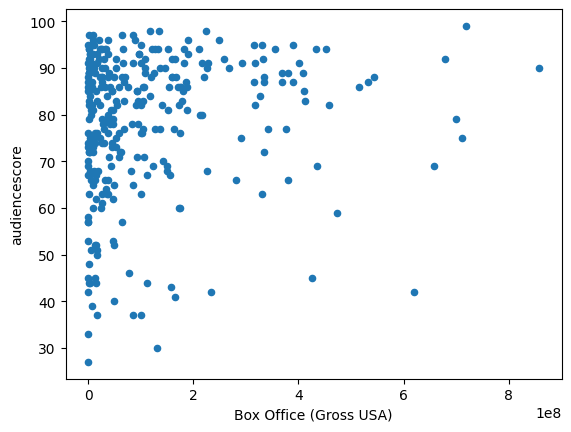

In [40]:
# draw a scatter plot between the box office and the audience score
import matplotlib
df_expensive.plot.scatter(x='Box Office (Gross USA)', y='audiencescore')